<a href="https://colab.research.google.com/github/210B/AttentionMechanisms-Transformers/blob/main/AttentionPooling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Before Starting...

In [1]:
!pip install d2l

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.7/111.7 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 59.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 52.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.4/123.4 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.3/98.3 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 341.8/341.8 kB 18.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.5/93.5 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 30.6 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.11.4
    Uninstalling scipy-1.11.4:
      Successfully uninstalled scipy-1.11.4
  Attempting uninstall: pyparsing
    Found existing installation: pyparsing 3.1.1
    Uninstalling pyparsing-3.1.1:
   

In [3]:
import torch
from d2l import torch as d2l

#Attention

In [ ]:
def show_heatmaps(matrices, xlabel, ylabel, titles=None, figsize=(2.5, 2.5),cmap='Reds'):
  """Show heatmaps of matrices."""
  d2l.use_svg_display()
  num_rows, num_cols, _, _ = matrices.shape
  fig, axes = d2l.plt.subplots(num_rows, num_cols, figsize=figsize, sharex=True, sharey=True, squeeze=False)
  for i, (row_axes, row_matrices) in enumerate(zip(axes, matrices)):
    for j, (ax, matrix) in enumerate(zip(row_axes, row_matrices)):
      pcm = ax.imshow(matrix.detach().numpy(), cmap=cmap)
      if i == num_rows - 1:
        ax.set_xlabel(xlabel)
      if j == 0:
        ax.set_ylabel(ylabel)
      if titles:
        ax.set_title(titles[j])
  fig.colorbar(pcm, ax=axes, shrink=0.6);

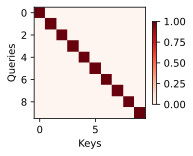

In [ ]:
attention_weights = torch.eye(10).reshape((1, 1, 10, 10))
show_heatmaps(attention_weights, xlabel='Keys', ylabel='Queries')

#KDE

In [1]:
# Define some kernels
def gaussian(x):
  return torch.exp(-x**2 / 2)
def boxcar(x):
  return torch.abs(x) < 1.0
def constant(x):
  return 1.0 + 0 * x
def epanechikov(x):
  return torch.max(1 - torch.abs(x), torch.zeros_like(x))

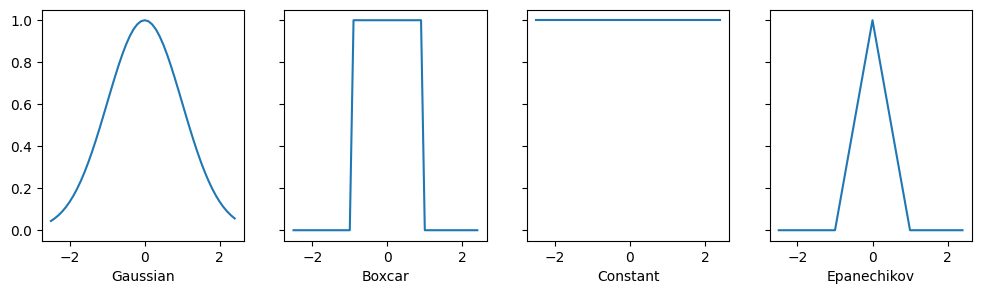

In [4]:
fig, axes = d2l.plt.subplots(1, 4, sharey=True, figsize=(12, 3))

kernels = (gaussian, boxcar, constant, epanechikov)
names = ('Gaussian', 'Boxcar', 'Constant', 'Epanechikov')
x = torch.arange(-2.5, 2.5, 0.1)
for kernel, name, ax in zip(kernels, names, axes):
  ax.plot(x.detach().numpy(), kernel(x).detach().numpy())
  ax.set_xlabel(name)

d2l.plt.show()

In [5]:
def f(x):
  return 2 * torch.sin(x) + x
n = 40
x_train, _ = torch.sort(torch.rand(n) * 5)
y_train = f(x_train) + torch.randn(n)
x_val = torch.arange(0, 5, 0.1)
y_val = f(x_val)

In [6]:
def nadaraya_watson(x_train, y_train, x_val, kernel):
  dists = x_train.reshape((-1, 1)) - x_val.reshape((1, -1))
  # Each column/row corresponds to each query/key
  k = kernel(dists).type(torch.float32)
  # Normalization over keys for each query
  attention_w = k / k.sum(0)
  y_hat = y_train@attention_w
  return y_hat, attention_w

In [7]:
def plot(x_train, y_train, x_val, y_val, kernels, names, attention=False):
  fig, axes = d2l.plt.subplots(1, 4, sharey=True, figsize=(12, 3))
  for kernel, name, ax in zip(kernels, names, axes):
    y_hat, attention_w = nadaraya_watson(x_train, y_train, x_val, kernel)
    if attention:
      pcm = ax.imshow(attention_w.detach().numpy(), cmap='Reds')
    else:
      ax.plot(x_val, y_hat)
      ax.plot(x_val, y_val, 'm--')
      ax.plot(x_train, y_train, 'o', alpha=0.5);
    ax.set_xlabel(name)
    if not attention:
      ax.legend(['y_hat', 'y'])
  if attention:
    fig.colorbar(pcm, ax=axes, shrink=0.7)


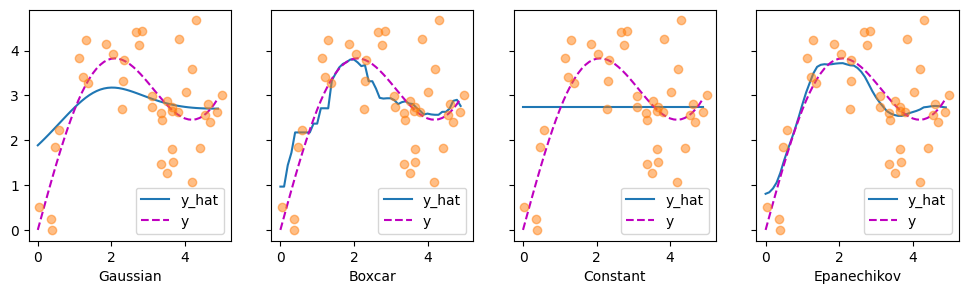

In [8]:
plot(x_train, y_train, x_val, y_val, kernels, names)

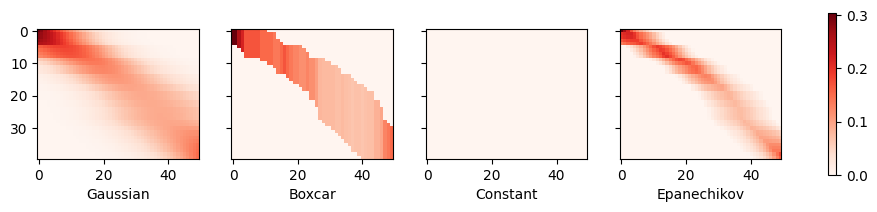

In [9]:
plot(x_train, y_train, x_val, y_val, kernels, names, attention=True)

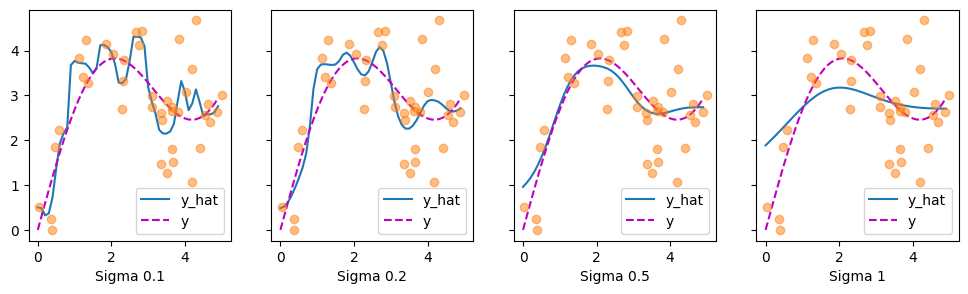

In [10]:
sigmas = (0.1, 0.2, 0.5, 1)
names = ['Sigma ' + str(sigma) for sigma in sigmas]
def gaussian_with_width(sigma):
  return (lambda x: torch.exp(-x**2 / (2*sigma**2)))
kernels = [gaussian_with_width(sigma) for sigma in sigmas]
plot(x_train, y_train, x_val, y_val, kernels, names)

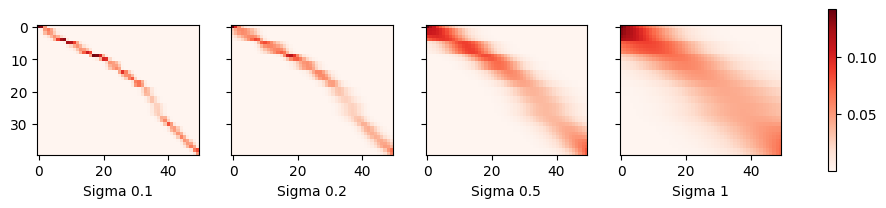

In [11]:
plot(x_train, y_train, x_val, y_val, kernels, names, attention=True)